# Encoding the Audio

In [1]:
import sys 
import os 
import pickle 
import numpy as np
import spacy
import seaborn as sns
import matplotlib as plt 
import matplotlib.pyplot as plt 
import pandas as pd

sys.path.append(os.path.abspath("../lingpred_new/"))
from plotting import colours
from encoding_analysis import regress_out_one, make_arbitrary_static_vectors, brainscore_no_coef
from utils import get_words_onsets_offsets, get_indices_per_task, make_y_matrix_per_run, get_runs


In [2]:
dataset               = 'Goldstein' # or Armeni
use_real_word_offsets = True

# dummy variables needed for that get_run functions
session = 1
subject = 1
task    = '0'

# Let's get X matrices for arbitrary vectors:
runs     = get_runs(dataset, session, subject, task)
words_df = pd.DataFrame() 

for run in runs:
    if len(runs)==1:
        words_df = get_words_onsets_offsets(dataset, subject=subject, session=session, run=run)
    else: 
        temp     = get_words_onsets_offsets(dataset, subject=subject, session=session, run=run)
        words_df = pd.concat([words_df, temp])
        
X        = make_arbitrary_static_vectors(words_df, dim=300)

# make an X matrix with residualised vectors
X_residualised = regress_out_one(X)
X.shape, X_residualised.shape


((5136, 300), (5135, 300))

In [3]:
# load the acoustic model:

if use_real_word_offsets:     
    if dataset == 'Armeni':
        with open('../audio/{}/acoustic_model_8_mels_averaged_per_word.pkl'.format(dataset), 'rb') as f:
            acoustics = pickle.load(f)
    elif dataset == 'Goldstein':
        with open('../audio/{}/acoustic_model_8_mels_averaged_per_word_using_word_offsets.pkl'.format(dataset), 'rb') as f:
            acoustics = pickle.load(f)
else:   
    with open('../audio/{}/acoustic_model_8_mels_averaged_per_word_using_next_word_onset_as_offset.pkl'.format(dataset), 'rb') as f:
        acoustics = pickle.load(f)

acoustics.shape

(5136, 9)

In [4]:
'''
# Compute the indices for making the y matrix
# -------------------------------------------
# This is already saved under audio/Goldstein/indices_all_tasks.pkl
# No need to run this again, as this would take  approx. 10 min

indices = get_indices_per_task(dataset)
indices.shape

dir_path = '/Users/ines/research/Lingpred/audio/Goldstein/'
file_name = 'indices_all_tasks.pkl'
path      = dir_path + file_name

print(path)
f = open(path,"wb")
pickle.dump(indices, f)
f.close()

'''

# load the indices:
if dataset == 'Goldstein':
    with open('../audio/Goldstein/indices_all_tasks.pkl', 'rb') as f:
        indices = pickle.load(f)
if dataset == 'Armeni':
    with open('../audio/Armeni/indices_session_1.pkl', 'rb') as f:
        indices = pickle.load(f)


indices.shape

(5136, 157)

In [5]:
# check that they look alright:
indices[:1], indices[-1:]

(array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
         4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
         5, 5, 5]]),
 array([[5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129,
         5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129,
         5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129,
         5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5129, 5130, 5130,
         5130, 5130, 5130, 5131, 5131, 5131, 5131, 5131, 5132, 5132, 5132,
         5132, 5132, 5133, 5133, 5133, 5133, 5133, 5133, 5133, 5133, 5133,
    

In [6]:
# use indices to make an acoustic y matrix of shape (length, 157, dim)
y_acoustics = make_y_matrix_per_run(acoustics, indices)
y_acoustics.shape

(5136, 157, 9)

In [7]:
y_acoustics[0, 0:10, 0] # check the first 9 values for the first timepoint/word

array([-6.57603264, -6.57603264, -6.57603264, -6.57603264, -6.57603264,
       -6.57603264, -6.57603264, -6.57603264, -6.57603264, -6.57603264])

In [8]:
words_df.head(9)


,word,onset,offset
0,Act,3.710,3.790
1,"one,",3.990,4.190
2,monkey,4.651,4.931
3,in,4.951,5.011
4,the,5.051,5.111
5,middle.,5.151,5.391
6,So,6.592,6.732
7,there's,6.752,6.912
8,some,6.892,7.052


In [9]:
nlp     = spacy.load('en_core_web_lg')
X_Glove = np.vstack([nlp(word).vector for word in words_df.word]) # np array of shape (nr_words, 300)
PoS     = [nlp(word)[0].pos_ for word in words_df.word]
#X_Glove = np.array(X_Glove.get()) # transform from cupy to numpy array for stacking later on 


X_Glove_residualised = regress_out_one(X_Glove)
X_Glove.shape, X_Glove_residualised.shape
    

((5136, 300), (5135, 300))

In [10]:
# compute encoding for residual GloVe and arbitrary vectors:
y = y_acoustics[1:]
y = np.swapaxes(np.swapaxes(y, 0, 1), 0, 2)
print('y should be of shape: (nr_mels, nr_words, nr_timepoints')
print('y has shape ', y.shape)

encoding_arbitrary_residualised = brainscore_no_coef(X_residualised, y)
encoding_Glove_residualised     = brainscore_no_coef(X_Glove_residualised, y)

y should be of shape: (nr_mels, nr_words, nr_timepoints
y has shape  (9, 8621, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 8621, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 8621, 157)


In [11]:
# compute encoding for original GloVe and arbitrary vectors:
y = y_acoustics
y = np.swapaxes(np.swapaxes(y, 0, 1), 0, 2)
print('y should be of shape: (nr_mels, nr_words, nr_timepoints')
print('y has shape ', y.shape)

encoding_arbitrary = brainscore_no_coef(X, y)
encoding_Glove     = brainscore_no_coef(X_Glove, y)

y should be of shape: (nr_mels, nr_words, nr_timepoints
y has shape  (9, 8622, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 8622, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 8622, 157)


In [12]:
if dataset == 'Goldstein':  
    with open('../audio/Goldstein/X_GPT_original_and_residualised_layer_47.pkl', 'rb') as f:
        X_matrices_GPT = pickle.load(f)
if dataset == 'Armeni':
    with open('../audio/Armeni/X_y_matrices_Glove_GPT_arbitrary_session_1.pkl', 'rb') as f:
        X_matrices_GPT = pickle.load(f)
X_matrices_GPT.keys()

dict_keys(['y_Glove', 'X_Glove', 'y_GPT', 'X_GPT', 'y_arbitrary', 'X_arbitrary'])

In [13]:
if dataset == 'Armeni':
    X_GPT              = X_matrices_GPT['X_GPT']
    X_GPT_residualised = regress_out_one(X_GPT)
if dataset == 'Goldstein':
    X_GPT              = X_matrices_GPT['X_GPT_layer_47']
    X_GPT_residualised = X_matrices_GPT['X_GPT_residualised_layer_47']


In [14]:
# compute encoding for GPT both regressed out and original GPT:
y = y_acoustics
y = np.swapaxes(np.swapaxes(y, 0, 1), 0, 2)

encoding_GPT  = brainscore_no_coef(X_GPT, y)

y                         = np.swapaxes(np.swapaxes(y_acoustics[1:], 0, 1), 0, 2)
encoding_GPT_residualised = brainscore_no_coef(X_GPT_residualised, y)

We are now in the brainscore_no_coef method, and y has shape:
(9, 8622, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 8621, 157)


In [15]:
# Let's save the results with original vectors in one file:
directory = '../audio/{}/'.format(dataset)
file_name = 'vectors_GPT_Glove_arbitrary_y_matrix_like_selfpred.pkl'
path      = directory + file_name
print(path)

keys    = ['corr_GPT', 'corr_Glove', 'corr_arbitrary']
values  = [encoding_GPT, encoding_Glove, encoding_arbitrary]
results = dict(zip(keys, values))

f = open(path,"wb")
pickle.dump(results, f)
f.close()


# Let's save the regressed out result in one file:
directory = '../audio/{}/'.format(dataset)
file_name = 'regressed_out_vectors_Glove_arbitrary_y_matrix_like_selfpred.pkl'
path      = directory + file_name
print(path)

keys    = ['corr_GPT','corr_Glove', 'corr_arbitrary']
values  = [encoding_GPT_residualised, encoding_Glove_residualised, encoding_arbitrary_residualised]
res_results = dict(zip(keys, values))

f = open(path,"wb")
pickle.dump(res_results, f)
f.close()

../audio/Armeni/vectors_GPT_Glove_arbitrary_y_matrix_like_selfpred.pkl
../audio/Armeni/regressed_out_vectors_Glove_arbitrary_y_matrix_like_selfpred.pkl


## Plots

In [19]:
from plotting import times_100, lowerCI, upperCI, reshape

Text(0.5, 1.0, 'Armeni:')

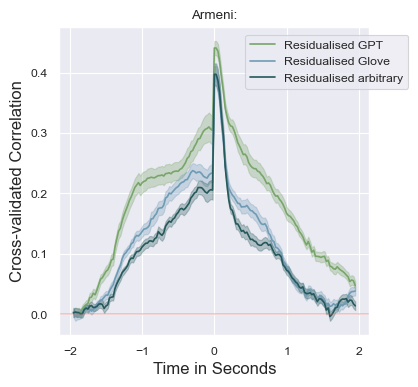

In [21]:
# get model names
models = [k.split(sep='_')[1] for k in results.keys()]
labels = ['Residualised ' + m for m in models]
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate(res_results.keys()):
    ax1.plot(times_100, res_results[key].mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(res_results[key])), 
                                upperCI(reshape(res_results[key])), color=colours[models[i]], alpha=0.3)

ax1.legend(loc=(0.6,0.8))
#ax1.set_ylim([-0.005, 0.05])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+':')

Text(0.5, 1.0, 'Armeni:')

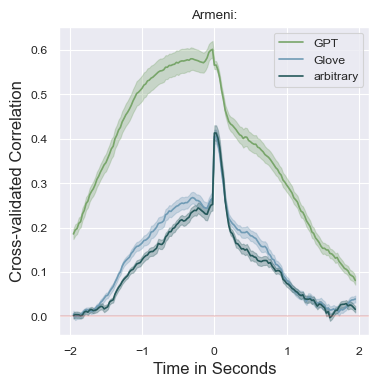

In [22]:
# get model names
models = [k.split(sep='_')[1] for k in res_results.keys()]
labels = [m for m in models]
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate(results.keys()):
    ax1.plot(times_100, results[key].mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(results[key])), 
                                upperCI(reshape(results[key])), color=colours[models[i]], alpha=0.3)

ax1.legend()
#ax1.set_ylim([-0.005, 0.05])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+':' )

### Histogram of the difference in values when encoding from residualised vs. original vectors

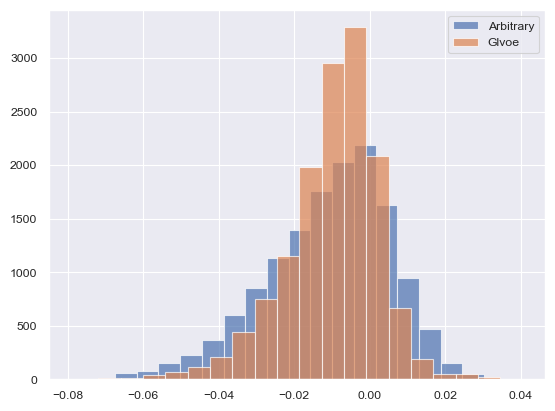

In [18]:
diff = encoding_arbitrary_residualised - encoding_arbitrary
diff.flatten().shape
plt.hist(diff.flatten(), bins=20, alpha=0.7, label='Arbitrary')
diff = encoding_Glove_residualised - encoding_Glove
diff.flatten().shape
plt.hist(diff.flatten(), bins=20, alpha=0.7, label='Glvoe')
plt.legend()

### Arbitrary encoding: Residualised vs. Orignial vectors

Text(0.5, 1.0, 'Armeni: arbitrary')

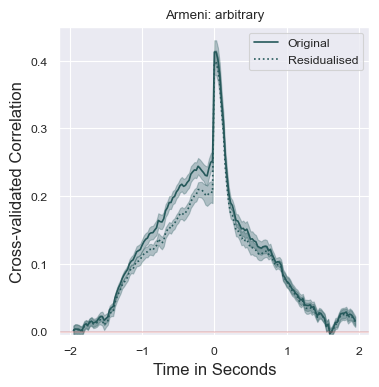

In [23]:
# get model names
models = ['arbitrary', 'arbitrary']
labels = ['Original', 'Residualised']
linestyles = {'Original': '-', 'Residualised': ':'}
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_arbitrary, encoding_arbitrary_residualised]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i], linestyle=linestyles[labels[i]])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.45])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+': ' + models[0])

### GloVe encoding: Residualised vs. Original Vectors 

Text(0.5, 1.0, 'Armeni: Glove')

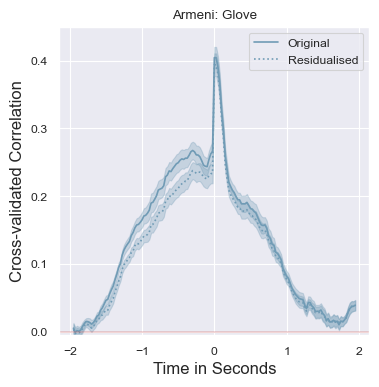

In [24]:
# get model names
models = ['Glove', 'Glove']
labels = ['Original', 'Residualised']
linestyles = {'Original': '-', 'Residualised': ':'}
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove, encoding_Glove_residualised]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i], linestyle=linestyles[labels[i]])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.45])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+': ' + models[0])

Text(0.5, 1.0, 'Armeni: GPT')

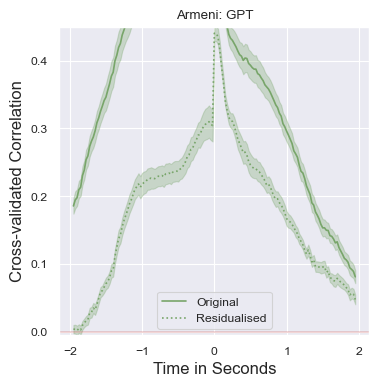

In [25]:
# get model names
models = ['GPT', 'GPT']
labels = ['Original', 'Residualised']
linestyles = {'Original': '-', 'Residualised': ':'}
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_GPT, encoding_GPT_residualised]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i], linestyle=linestyles[labels[i]])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.45])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+': ' + models[0])

## Difference of Predictability on encoding 

In [10]:
if dataset == 'Goldstein':
    df = pd.read_csv('../Goldstein_gpt_features/transcript_data_gpt.txt', 
                                sep='\t',
                                index_col='Unnamed: 0')
    # first we only want to keep the word-initial token of a word:
    mask_first = df["word_idx"] != df["word_idx"].shift(1)
    df_first   = df[mask_first]

    is_top_1     = [x < 1 for x in df_first['rank']] # rank 0 is the Top-1 prediction
    is_not_top_1 = [not x for x in is_top_1]
    is_top_5     = [x < 5 for x in df_first['rank']] # rank 4 is the Top-5 prediction
    is_not_top_5 = [not x for x in is_top_5]

if dataset == 'Armeni':
    with open('../audio/Armeni/Dataframe_WordSurprisal_Top10Words_All_Sessions.pkl', 'rb') as f:
        df = pickle.load(f)
    is_top_1 = df.is_Top_1.to_list()[:X_Glove.shape[0]]
    is_not_top_1 = [not x for x in is_top_1]
    is_top_5     = df.is_Top_5.to_list()[:X_Glove.shape[0]]
    is_not_top_5 = [not x for x in is_top_5]

print(np.unique(is_top_1, return_counts=True))
print(np.unique(is_top_5, return_counts=True))

(array([False,  True]), array([3651, 1485]))
(array([False,  True]), array([2532, 2604]))


In [18]:
'''Alternative way of defining Top-1 and Top-5 for Goldstein '''

if dataset == 'Goldstein':
    # group by word_idx
    groups = df.groupby("word_idx")

    # condition: for each word_idx, check if ALL ranks are 0
    mask_all_zero = groups["rank"].transform(lambda x: (x == 0).all())
    mask_all_less_5 = groups["rank"].transform(lambda x: (x < 5).all())  

    len(mask_all_zero[mask_first])
    np.unique(mask_all_zero[mask_first], return_counts=True), np.unique(mask_all_less_5[mask_first], return_counts=True)

This means we have 1485 trials in which the word-initial token is the Top-1 predictions and 2604 trials for which it is among the Top-5 predictions

In [11]:
y_acoustics.shape, X_Glove_residualised.shape, len(is_top_1)

((5136, 157, 9), (5135, 300), 5136)

### First for the original vectors:

In [ ]:
y = y_acoustics

X_Glove_top_1     = X_Glove[is_top_1]
X_Glove_top_5     = X_Glove[is_top_5]
X_Glove_not_top_1 = X_Glove[is_not_top_1]
X_Glove_not_top_5 = X_Glove[is_not_top_5]

y_top_1     = y[is_top_1]
y_top_5     = y[is_top_5]
y_not_top_1 = y[is_not_top_1]
y_not_top_5 = y[is_not_top_5]

y_top_1 = np.swapaxes(np.swapaxes(y_top_1, 1, 2), 0, 1)
y_top_5 = np.swapaxes(np.swapaxes(y_top_5, 1, 2), 0, 1)
y_not_top_1 = np.swapaxes(np.swapaxes(y_not_top_1, 1, 2), 0, 1)
y_not_top_5 = np.swapaxes(np.swapaxes(y_not_top_5, 1, 2), 0, 1)


In [68]:
# compute the encoding of the acoustics for each split
encoding_Glove_top_1     = brainscore_no_coef(X_Glove_top_1, y_top_1)
encoding_Glove_top_5     = brainscore_no_coef(X_Glove_top_5, y_top_5)
encoding_Glove_not_top_1 = brainscore_no_coef(X_Glove_not_top_1, y_not_top_1)
encoding_Glove_not_top_5 = brainscore_no_coef(X_Glove_not_top_5, y_not_top_5)

We are now in the brainscore_no_coef method, and y has shape:
(9, 1485, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 2604, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 3651, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 2532, 157)


### and now for the residualised ones:

In [37]:
# Since we are working with residualised vectors, which is not defined for the first word, we need to drop that for our is_top_ masks
y = y_acoustics[1:]

is_top_1     = is_top_1[1:]
is_top_5     = is_top_5[1:]
is_not_top_1 = is_not_top_1[1:]
is_not_top_5 = is_not_top_5[1:]

len(is_top_1), len(is_top_5), len(is_not_top_1), len(is_not_top_5), y.shape

(8621, 8621, 8621, 8621, (8621, 157, 9))

In [38]:
y_top_1     = y[is_top_1]
y_top_5     = y[is_top_5]
y_not_top_1 = y[is_not_top_1]
y_not_top_5 = y[is_not_top_5]

X_Glove_residualised_top_1     = X_Glove_residualised[is_top_1]
X_Glove_residualised_top_5     = X_Glove_residualised[is_top_5]
X_Glove_residualised_not_top_1 = X_Glove_residualised[is_not_top_1]
X_Glove_residualised_not_top_5 = X_Glove_residualised[is_not_top_5]

y_top_1.shape, X_Glove_residualised_top_1.shape

((3074, 157, 9), (3074, 300))

In [39]:
y_top_1 = np.swapaxes(np.swapaxes(y_top_1, 1, 2), 0, 1)
y_top_5 = np.swapaxes(np.swapaxes(y_top_5, 1, 2), 0, 1)
y_not_top_1 = np.swapaxes(np.swapaxes(y_not_top_1, 1, 2), 0, 1)
y_not_top_5 = np.swapaxes(np.swapaxes(y_not_top_5, 1, 2), 0, 1)

In [40]:
# compute the encoding of the acoustics for each split
encoding_Glove_residualised_top_1     = brainscore_no_coef(X_Glove_residualised_top_1, y_top_1)
encoding_Glove_residualised_top_5     = brainscore_no_coef(X_Glove_residualised_top_5, y_top_5)
encoding_Glove_residualised_not_top_1 = brainscore_no_coef(X_Glove_residualised_not_top_1, y_not_top_1)
encoding_Glove_residualised_not_top_5 = brainscore_no_coef(X_Glove_residualised_not_top_5, y_not_top_5)

We are now in the brainscore_no_coef method, and y has shape:
(9, 3074, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 5053, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 5547, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 3568, 157)


Text(0.5, 1.0, 'Armeni Audio Encoding from Residual Vectors: Top 1')

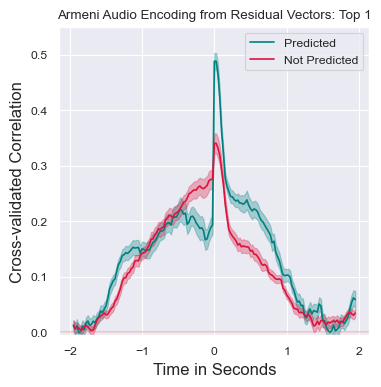

In [43]:
# get model names
models = ['Top 1', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_residualised_top_1, encoding_Glove_residualised_not_top_1]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding from Residual Vectors: ' + models[0])

Text(0.5, 1.0, 'Goldstein Audio Encoding: Original Vectors Top 1')

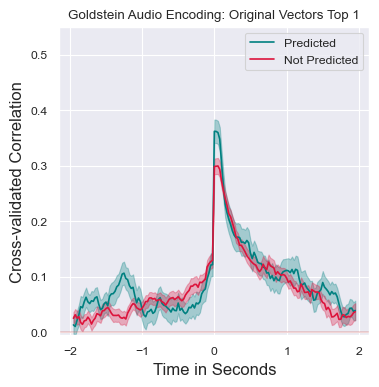

In [69]:
# get model names
models = ['Top 1', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_top_1, encoding_Glove_not_top_1]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: Original Vectors ' + models[0])

Text(0.5, 1.0, 'Armeni Audio Encoding: ResidualTop 5')

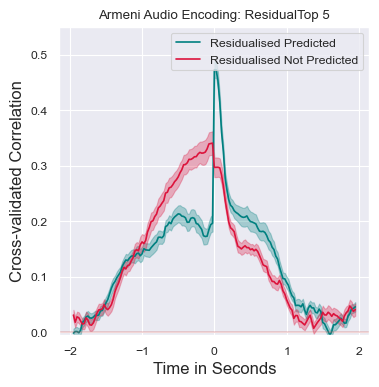

In [46]:
# get model names
models = ['Top 5', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_residualised_top_5, encoding_Glove_residualised_not_top_5]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label='Residualised ' +labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: Residual' + models[0])

### Look at the PoS distribution in each split

In [12]:
len(PoS), len(words_df), len(is_top_1)

(5136, 5136, 5136)

In [13]:
if dataset == 'Goldstein':
    df = pd.read_csv('../Goldstein_gpt_features/transcript_data_gpt.txt', 
                                sep='\t',
                                index_col='Unnamed: 0')
    # first we only want to keep the word-initial token of a word:
    mask_first = df["word_idx"] != df["word_idx"].shift(1)
    df_first   = df[mask_first]

    is_top_1     = [x < 1 for x in df_first['rank']] # rank 0 is the Top-1 prediction
    is_not_top_1 = [not x for x in is_top_1]
    is_top_5     = [x < 5 for x in df_first['rank']] # rank 4 is the Top-5 prediction
    is_not_top_5 = [not x for x in is_top_5]

if dataset == 'Armeni':
    with open('../audio/Armeni/Dataframe_WordSurprisal_Top10Words_All_Sessions.pkl', 'rb') as f:
        df = pickle.load(f)
    is_top_1 = df.is_Top_1.to_list()[:X_GPT.shape[0]]
    is_not_top_1 = [not x for x in is_top_1]
    is_top_5     = df.is_Top_5.to_list()[:X_GPT.shape[0]]
    is_not_top_5 = [not x for x in is_top_5]

print(np.unique(is_top_1, return_counts=True))
print(np.unique(is_top_5, return_counts=True))

(array([False,  True]), array([3651, 1485]))
(array([False,  True]), array([2532, 2604]))


In [52]:
PoS_top_1     = np.array(PoS)[is_top_1]
PoS_not_top_1 = np.array(PoS)[is_not_top_1]

len(PoS_top_1), len(PoS_not_top_1)

(3075, 5547)

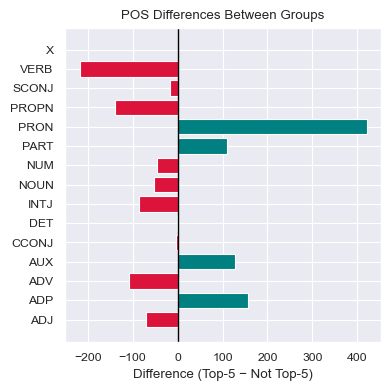

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Count frequencies
counts_top1 = Counter(PoS_top_1)
counts_not_top1 = Counter(PoS_not_top_1)

# Union of all POS tags
all_tags = sorted(set(counts_top1.keys()) | set(counts_not_top1.keys()))

# Align counts
top1_vals = np.array([counts_top1.get(tag, 0) for tag in all_tags])
not_top1_vals = np.array([counts_not_top1.get(tag, 0) for tag in all_tags])

# Option 1: difference in counts
diff_vals = top1_vals - not_top1_vals

# Option 2: difference in proportions (uncomment if you prefer)
# top1_vals = top1_vals / top1_vals.sum()
# not_top1_vals = not_top1_vals / not_top1_vals.sum()
# diff_vals = top1_vals - not_top1_vals

# Plot
y = np.arange(len(all_tags))

plt.figure(figsize=(4, 4))
bars = plt.barh(y, diff_vals, color=["teal" if v > 0 else "crimson" for v in diff_vals])

plt.yticks(y, all_tags)
plt.axvline(0, color="black", linewidth=1)
plt.xlabel("Difference (Top-5 − Not Top-5)")
plt.title("POS Differences Between Groups")
plt.tight_layout()
plt.show()


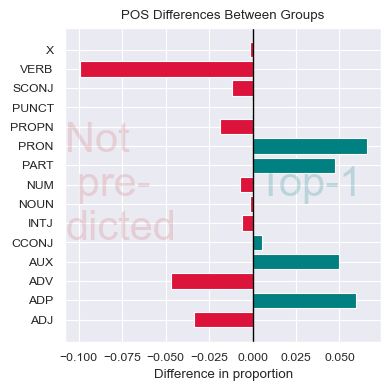

In [53]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

# Count frequencies
counts_top1     = Counter(PoS_top_1)
counts_not_top1 = Counter(PoS_not_top_1)

# Union of all POS tags
all_tags = sorted(set(counts_top1.keys()) | set(counts_not_top1.keys()))

# Align counts
top1_vals = np.array([counts_top1.get(tag, 0) for tag in all_tags])
not_top1_vals = np.array([counts_not_top1.get(tag, 0) for tag in all_tags])

# Normalise to proportions
top1_vals     = top1_vals / top1_vals.sum()
not_top1_vals = not_top1_vals / not_top1_vals.sum()
diff_vals     = top1_vals - not_top1_vals

# Plot
y       = np.arange(len(all_tags))
fig, ax = plt.subplots(figsize=(4, 4))

ax.barh(y, diff_vals, color=["teal" if v > 0 else "crimson" for v in diff_vals])

ax.set_yticks(y)
ax.set_yticklabels(all_tags)
ax.axvline(0, color="black", linewidth=1)

ax.set_xlabel("Difference in proportion")
ax.set_title("POS Differences Between Groups")

# Get limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add background text
ax.text(xlim[1]*0.85, (ylim[0]+ylim[1])/2, "Top-1",
        ha="right", va="center", fontsize=30, color="teal", alpha=0.2, rotation=0)
ax.text(xlim[0]*1, (ylim[0]+ylim[1])/2, "Not \n pre- \ndicted",
        ha="left", va="center", fontsize=30, color="indianred", alpha=0.2, rotation=0)

plt.tight_layout()
plt.show()


In [54]:
if dataset == 'Goldstein':
    words_df['duration'] = words_df.end - words_df.onset
words_df

,onset,duration,sample,type,word,offset
3,1.089189,0.129705,4.663737e+04,word_onset_01,THE,1.218895
6,1.218895,0.678458,4.679302e+04,word_onset_01,ADVENTURES,1.897353
15,1.897353,0.089796,4.760717e+04,word_onset_01,OF,1.987149
18,1.987149,0.488889,4.771492e+04,word_onset_01,SHERLOCK,2.476037
24,2.476037,0.698413,4.830159e+04,word_onset_01,HOLMES,3.174450
...,...,...,...,...,...,...
41115,425.853815,0.548753,5.577619e+06,word_onset_07,HONOURABLE,426.402568
41123,426.402568,0.838095,5.578278e+06,word_onset_07,TITLE,427.240663
41131,428.058804,0.089796,5.580265e+06,word_onset_07,OF,428.148600
41134,428.148600,0.419048,5.580373e+06,word_onset_07,THE,428.567647


In [55]:
print(words_df[is_top_1].duration.mean(), words_df[is_top_1].duration.var())
print(words_df[is_not_top_1].duration.mean(), words_df[is_not_top_1].duration.var())


0.22931946978707637 0.02772627521099224
0.3070882628640193 0.03511334888635475


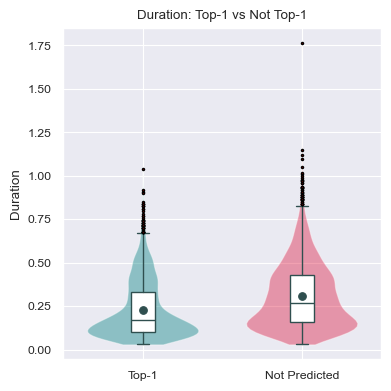

In [57]:
import matplotlib.pyplot as plt
import numpy as np

dur_top1 = words_df[is_top_1].duration.values
dur_not_top1 = words_df[is_not_top_1].duration.values

data = [dur_top1, dur_not_top1]
labels = ["Top-1", "Not Predicted"]

fig, ax = plt.subplots(figsize=(4,4))

for i, vals in enumerate(data, start=1):
    # violin
    parts = ax.violinplot(vals, positions=[i], showextrema=False, widths=0.7)
    for pc in parts['bodies']:
        pc.set_facecolor("teal" if i==1 else "crimson")
        pc.set_alpha(0.4)
    
    # boxplot
    box = ax.boxplot(vals, positions=[i], widths=0.15, patch_artist=True,
                     boxprops=dict(facecolor="white", color="darkslategrey"),
                     medianprops=dict(color="darkslategrey"),
                     whiskerprops=dict(color="darkslategrey"),
                     capprops=dict(color="darkslategrey"),
                     flierprops = dict(
                                        marker=".",
                                        markersize=3,
                                        markerfacecolor="red",
                                        linestyle="none"
                    ))
    
    # mean as a dot
    ax.scatter(i, np.mean(vals), color="darkslategrey", zorder=3, s=30)

ax.set_xticks([1,2])
ax.set_xticklabels(labels)
ax.set_ylabel("Duration")
ax.set_title("Duration: Top-1 vs Not Top-1")
plt.tight_layout()
plt.show()


### For each split, look at what type of words are in the pre-onset interval

In [58]:
preonset_indices = indices[:,:78]
preonset_indices.shape

(8622, 78)

In [59]:
preonset_indices_top_1     = preonset_indices[is_top_1]
preonset_indices_not_top_1 = preonset_indices[is_not_top_1]
nr_words_preonset_top_1     = [len(np.unique(x)) for x in preonset_indices_top_1]
nr_words_preonset_not_top_1 = [len(np.unique(x)) for x in preonset_indices_not_top_1]

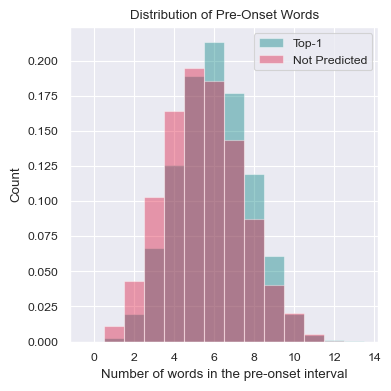

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(4,4))
plt.hist(nr_words_preonset_top_1, bins=range(0, max(max(nr_words_preonset_top_1),
                                                    max(nr_words_preonset_not_top_1))+2),
         density=True, alpha=0.4, label="Top-1", color="teal", align="left")
plt.hist(nr_words_preonset_not_top_1, bins=range(0, max(max(nr_words_preonset_top_1),
                                                        max(nr_words_preonset_not_top_1))+2),
         density=True, alpha=0.4, label="Not Predicted", color="crimson", align="left")

plt.xlabel("Number of words in the pre-onset interval")
plt.ylabel("Count")
plt.title("Distribution of Pre-Onset Words")
plt.legend()
plt.tight_layout()
plt.show()


In [62]:
words_preonset_top_1     = [words_df.word.iloc[x] for x in preonset_indices_top_1.flatten()]
words_preonset_not_top_1 = [words_df.word.iloc[x] for x in preonset_indices_not_top_1.flatten()]

In [63]:
PoS_preonset_top_1     = [nlp(word)[0].pos_ for word in words_preonset_top_1]
PoS_preonset_not_top_1 = [nlp(word)[0].pos_ for word in words_preonset_not_top_1]


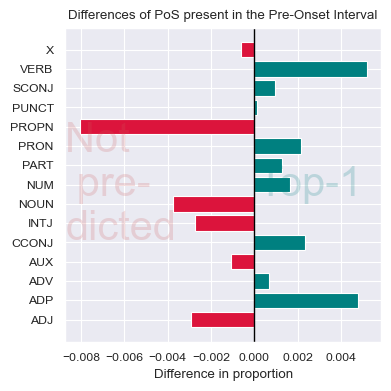

In [65]:
# Count frequencies
counts_top1 = Counter(PoS_preonset_top_1)
counts_not_top1 = Counter(PoS_preonset_not_top_1)

# Union of all POS tags
all_tags = sorted(set(counts_top1.keys()) | set(counts_not_top1.keys()))

# Align counts
top1_vals     = np.array([counts_top1.get(tag, 0) for tag in all_tags])
not_top1_vals = np.array([counts_not_top1.get(tag, 0) for tag in all_tags])

# Normalise to proportions
top1_vals     = top1_vals / top1_vals.sum()
not_top1_vals = not_top1_vals / not_top1_vals.sum()
diff_vals     = top1_vals - not_top1_vals

# Plot
y       = np.arange(len(all_tags))
fig, ax = plt.subplots(figsize=(4, 4))

ax.barh(y, diff_vals, color=["teal" if v > 0 else "crimson" for v in diff_vals])

ax.set_yticks(y)
ax.set_yticklabels(all_tags)
ax.axvline(0, color="black", linewidth=1)

ax.set_xlabel("Difference in proportion")
ax.set_title("Differences of PoS present in the Pre-Onset Interval")

# Get limits
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Add background text
ax.text(xlim[1]*0.85, (ylim[0]+ylim[1])/2, "Top-1",
        ha="right", va="center", fontsize=30, color="teal", alpha=0.2, rotation=0)
ax.text(xlim[0]*1, (ylim[0]+ylim[1])/2, "Not \n pre- \ndicted",
        ha="left", va="center", fontsize=30, color="indianred", alpha=0.2, rotation=0)

plt.tight_layout()
plt.show()


In [66]:
# Let's look at the acoustics themselves, do they look very different??
y_top_1.shape, y_not_top_1.shape

((9, 3074, 157), (9, 5547, 157))

In [67]:
preonset_y_top_1, preonset_y_not_top_1 = y_top_1[:,:,:78], y_not_top_1[:,:,:78]
preonset_y_top_1.shape, preonset_y_not_top_1.shape

((9, 3074, 78), (9, 5547, 78))

In [68]:
preonset_y_top_1[:, 0, 0]

array([ -3.18965149, -16.83115768, -30.60241699, -20.08598518,
       -21.69374657, -32.22709274, -44.04509735, -48.29707336,
       370.1706543 ])

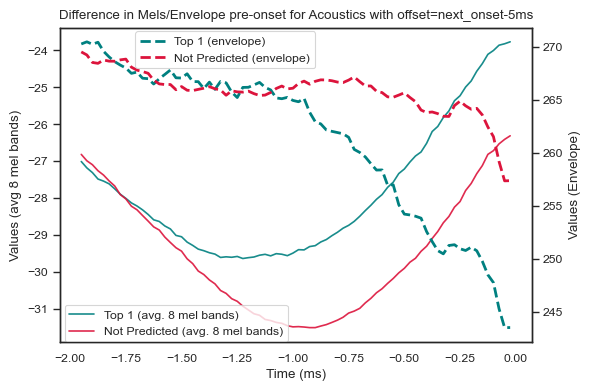

In [77]:

x = times_100[:78]
sns.set_style('white')

fig, ax1 = plt.subplots(figsize=(6, 4))
ax2 = ax1.twinx()  # right y-axis

colors = ['teal', 'crimson']
labels = ['Top 1', 'Not Predicted']

for data, color, label in zip([preonset_y_top_1, preonset_y_not_top_1],
                              colors, labels):
    mean = data.mean(axis=1)  # shape (9, 78)
    std = data.std(axis=1)

    # --- Average across first 8 ---
    avg_mean = mean[:8].mean(axis=0)
    avg_std = mean[:8].std(axis=0)

    ax1.plot(x, avg_mean, color=color, alpha=0.9, label=f"{label} (avg. 8 mel bands)")
    #ax1.fill_between(x, avg_mean-avg_std, avg_mean+avg_std, color=color, alpha=0.2)

    # --- Plot the 9th separately ---
    ax2.plot(x, mean[8], color=color, linestyle="--", linewidth=2, label=f"{label} (envelope)")
    #ax2.fill_between(x, mean[8]-std[8], mean[8]+std[8], color=color, alpha=0.15)

ax1.set_xlabel("Time (ms)")
ax1.set_ylabel("Values (avg 8 mel bands)")
#ax1.set_ylim((-13, -5))
#ax2.set_ylim((126, 182))
ax2.set_ylabel("Values (Envelope)")
ax2.legend(loc=(0.16, 0.87))
ax1.legend(loc=(0.01, 0))
if use_real_word_offsets:
    plt.title('Difference in Mels/Envelope pre-onset for Acoustics with real_word_offsets')
else:
    plt.title('Difference in Mels/Envelope pre-onset for Acoustics with offset=next_onset-5ms')
plt.tight_layout()
plt.show()


## we want to compare re-occurring bigrams vs. unique bigrams encoding for each dataset to see if that holds for Goldstein
since the re-occuring bigrams should be an extreme case of being more predictable prior to onset than unique bigrams

In [14]:
X_Glove.shape, len(words_df)

((5136, 300), 5136)

In [15]:
def get_bigram_duplicate_mask(df: pd.DataFrame, word_col: str = 'word') -> np.ndarray:
    """
    Returns indices of the first word in each duplicate bigram from a dataframe.
    
    Parameters:
    - df: pandas DataFrame containing a column of words
    - word_col: name of the column containing the words (default is 'word')
    
    Returns:
    - np.ndarray of indices corresponding to the first word of each duplicate bigram
    """

    df = df.copy()
    df['next_word'] = df[word_col].shift(-1)
    df['bigram']    = df[word_col] + '_' + df['next_word']
    df['indx']     = [x+1 for x in range(len(df))] # This column is the index shifted by one, since I am interested in the second word of the bigram. e.g, in the bigram monkey_in I want 'in' to be the time locked at t=0 word
    df_bigrams      = df[:-1].reset_index(drop=True)

    # keep only rows whose bigram occurs more than once
    dup_mask                 = df_bigrams.duplicated('bigram', keep=False)
    duplicate_bigram_indices = df_bigrams[dup_mask].indx

    # compute frequency counts
    bigram_counts = df_bigrams['bigram'].value_counts()
    # map back to dataframe
    df_bigrams['bigram_count'] = df_bigrams['bigram'].map(bigram_counts)

    print(df_bigrams[dup_mask].head(10))

    return duplicate_bigram_indices.to_numpy()

def get_unique_bigram_mask(df: pd.DataFrame, word_col: str = 'word') -> np.ndarray:
    """
    Returns indices of the first word in each duplicate bigram from a dataframe.
    
    Parameters:
    - df: pandas DataFrame containing a column of words
    - word_col: name of the column containing the words (default is 'word')
    
    Returns:
    - np.ndarray of indices corresponding to the first word of each duplicate bigram
    """

    df = df.copy()
    df['next_word'] = df[word_col].shift(-1)
    df['bigram']    = df[word_col] + '_' + df['next_word']
    df['indx']     = [x+1 for x in range(len(df))] # This column is the index shifted by one, since I am interested in the second word of the bigram. e.g, in the bigram monkey_in I want 'in' to be the time locked at t=0 word
    df_bigrams      = df[:-1].reset_index(drop=True)

    # keep only rows whose bigram occurs more than once
    dup_mask                 = df_bigrams.duplicated('bigram', keep=False)
    unique_mask              = [not x for x in dup_mask]
    unique_bigram_indices    = df_bigrams[unique_mask].indx

    # compute frequency counts
    bigram_counts = df_bigrams['bigram'].value_counts()
    # map back to dataframe
    df_bigrams['bigram_count'] = df_bigrams['bigram'].map(bigram_counts)

    print(df_bigrams[unique_mask].head(10))

    return unique_bigram_indices.to_numpy()

bigram_duplicate_mask = get_bigram_duplicate_mask(words_df)
bigram_unique_mask    = get_unique_bigram_mask(words_df)

print(len(bigram_duplicate_mask), len(bigram_unique_mask))

# make lengths equal by random sampling (without replacement)
'''if len(bigram_duplicate_mask) < len(bigram_unique_mask):
    bigram_unique_mask = np.random.choice(
        bigram_unique_mask,
        size=len(bigram_duplicate_mask),
        replace=False
    )
'''
print(len(bigram_duplicate_mask), len(bigram_unique_mask))

      word      onset     offset next_word     bigram  indx  bigram_count
2   monkey   4.651000   4.931000        in  monkey_in     3             4
3       in   4.951000   5.011000       the     in_the     4            29
16    that   9.862000   9.932000       are   that_are    17             2
26      up  14.432000  14.532000        in      up_in    27             2
27      in  14.572000  14.602000         a       in_a    28             7
30    like  14.872000  15.012000      that  like_that    31             3
40      as  17.562000  17.652000       you     as_you    41             2
42     can  17.782000  17.902000       get    can_get    43             2
51      in  22.193928  22.273928       the     in_the    52            29
61       A  26.193928  26.263928       few      A_few    62             2
       word  onset  offset next_word          bigram  indx  bigram_count
0       Act  3.710   3.790      one,        Act_one,     1             1
1      one,  3.990   4.190    monkey    

In [19]:
for bool, word in zip(is_top_1[0:6], ['Act', 'One', 'Monkey', 'in', 'the', 'middle.']):
    print(word, '\t:', bool)

Act 	: False
One 	: False
Monkey 	: False
in 	: False
the 	: True
middle. 	: True


In [54]:
y_bigrams        = y_acoustics[bigram_duplicate_mask]
X_Glove_bigrams  = X_Glove[bigram_duplicate_mask]

y_nobigrams        = y_acoustics[bigram_unique_mask]
X_Glove_nobigrams  = X_Glove[bigram_unique_mask]

In [55]:

y_bigrams   = np.swapaxes(np.swapaxes(y_bigrams, 1, 2), 0, 1)
y_nobigrams = np.swapaxes(np.swapaxes(y_nobigrams, 1, 2), 0, 1)

y_bigrams.shape

(9, 1578, 157)

In [56]:

encoding_Glove_bigrams   = brainscore_no_coef(X_Glove_bigrams, y_bigrams)
encoding_Glove_nobigrams = brainscore_no_coef(X_Glove_nobigrams, y_nobigrams)

We are now in the brainscore_no_coef method, and y has shape:
(9, 1578, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 3557, 157)


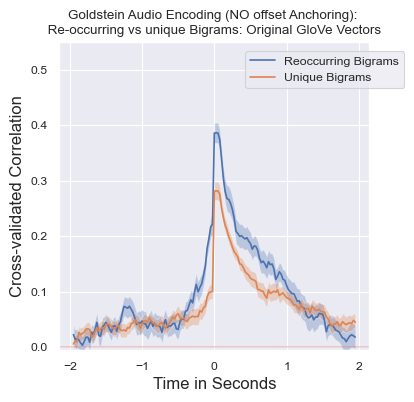

In [57]:
# get model names
from lingpred_new.plotting import times_100, lowerCI, upperCI, reshape

models = ['Reoccurring Bigrams', 'Unique Bigrams']
labels = models
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_bigrams, encoding_Glove_nobigrams]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), alpha=0.3)

ax1.legend(loc=(0.6, 0.85))
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
if use_real_word_offsets:
    ax1.set_title(dataset+' Audio Encoding (NO offset Anchoring): \n Re-occurring vs unique Bigrams: Original GloVe Vectors ')
else:
    ax1.set_title(dataset+' Audio Encoding (OFFSET ANCHORING!): \n Re-occurring vs unique Bigrams: Original GloVe Vectors ')

## Let's look at residualisation and if that has an impact at all 

In order to look at the residual encoding I need to shift all the indices back by one, since the first vector in the residual X matrix corresponds to the second word. E.g.: Act One, Monkey in the Middle. The vector at X[0] is the vector for 'One' for which 'Act' has been regressed out. So if the duplicates mask tells me, keep the vector number 3, corresponding to 'in' since monkey_in is a re-occurring bigram, I now need to keep the regressed out vector for in, which is at the position X[2] not X[3]

In [115]:
bigram_unique_mask_residualised    = [x-1 for x in bigram_unique_mask]
bigram_duplicate_mask_residualised = [x-1 for x in bigram_duplicate_mask]

X_Glove_residualised_bigrams    = X_Glove_residualised[bigram_duplicate_mask_residualised]
X_Glove_residualised_no_bigrams = X_Glove_residualised[bigram_unique_mask_residualised]

X_Glove_residualised_bigrams.shape, X_Glove_residualised_no_bigrams.shape

((1578, 300), (3557, 300))

In [116]:
y_bigrams.shape, y_nobigrams.shape

((9, 1578, 157), (9, 3557, 157))

In [117]:

encoding_Glove_residualised_bigrams   = brainscore_no_coef(X_Glove_residualised_bigrams, y_bigrams)
encoding_Glove_residualised_nobigrams = brainscore_no_coef(X_Glove_residualised_no_bigrams, y_nobigrams)

We are now in the brainscore_no_coef method, and y has shape:
(9, 1578, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 3557, 157)


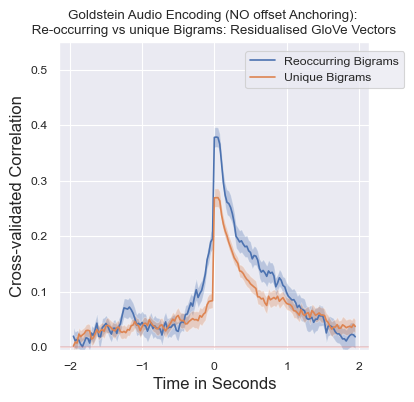

In [119]:

models = ['Reoccurring Bigrams', 'Unique Bigrams']
labels = models
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_residualised_bigrams, encoding_Glove_residualised_nobigrams]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), alpha=0.3)

ax1.legend(loc=(0.6, 0.85))
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
if use_real_word_offsets:
    ax1.set_title(dataset+' Audio Encoding (NO offset Anchoring): \n Re-occurring vs unique Bigrams: Residualised GloVe Vectors ')
else:
    ax1.set_title(dataset+' Audio Encoding (OFFSET ANCHORING!): \n Re-occurring vs unique Bigrams: Residualised GloVe Vectors ')

### Let's look at the overlap between our re-occuring bigrams and the Top-1 and Top-5 prediction by GPT

In [51]:
top_1_indices = np.array(range(len(is_top_1)))[is_top_1]
not_top_1_indices = np.array(range(len(is_top_1)))[is_not_top_1]
top_1_indices, not_top_1_indices

(array([   4,    5,   10, ..., 5127, 5129, 5132], shape=(1485,)),
 array([   0,    1,    2, ..., 5133, 5134, 5135], shape=(3651,)))

In [52]:
top_1_and_reoccuring_bigram = [x for x in top_1_indices if x in bigram_duplicate_mask]
print("Number reoccurring bigrams which are the Top-1 prediction:", len(top_1_and_reoccuring_bigram))
print("Out of", len(bigram_duplicate_mask))

Number reoccurring bigrams which are the Top-1 prediction: 701
Out of 1578


In [53]:
top_5_indices = np.array(range(len(is_top_5)))[is_top_5]
top_5_and_reoccuring_bigram = [x for x in top_5_indices if x in bigram_duplicate_mask]

print("Number reoccurring bigrams which are the Top-5 prediction:", len(top_5_and_reoccuring_bigram))
print("Out of ", len(bigram_duplicate_mask))

Number reoccurring bigrams which are the Top-5 prediction: 1082
Out of  1578


In [61]:
top_1_and_unique_bigram = [x for x in top_1_indices if x in bigram_unique_mask]
print("Number unique bigrams which are the Top-1 prediction:", len(top_1_and_unique_bigram))
print("Out of", len(bigram_unique_mask))

Number unique bigrams which are the Top-1 prediction: 784
Out of 3557


In [62]:
y_unique_top1_bigrams        = y_acoustics[top_1_and_unique_bigram]
X_Glove_unique_top1_bigrams  = X_Glove[top_1_and_unique_bigram]

y_unique_top1_bigrams = np.swapaxes(np.swapaxes(y_unique_top1_bigrams, 1, 2), 0, 1)
y_unique_top1_bigrams.shape

(9, 784, 157)

In [63]:
y_not_top1        = y_acoustics[is_not_top_1]
X_Glove_not_top1  = X_Glove[is_not_top_1]

y_not_top1 = np.swapaxes(np.swapaxes(y_not_top1, 1, 2), 0, 1)
y_not_top1.shape

(9, 3651, 157)

In [64]:
encoding_Glove_unique_top1_bigrams = brainscore_no_coef(X_Glove_unique_top1_bigrams, y_unique_top1_bigrams)
encoding_Glove_not_top1 = brainscore_no_coef(X_Glove_not_top1, y_not_top1)

We are now in the brainscore_no_coef method, and y has shape:
(9, 784, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 3651, 157)


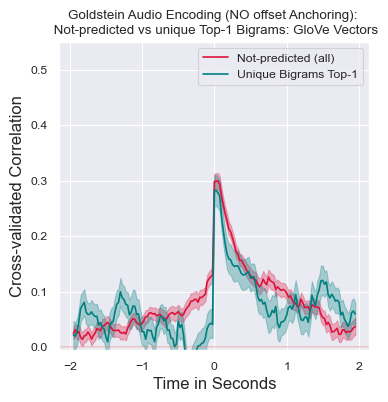

In [65]:
# get model names
from lingpred_new.plotting import times_100, lowerCI, upperCI, reshape
models = ['Not Predicted', 'Top 1']
labels = ['Not-predicted (all)', 'Unique Bigrams Top-1']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_not_top1, encoding_Glove_unique_top1_bigrams]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), label=labels[i], color=colours[models[i]])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]],alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
if use_real_word_offsets:
    ax1.set_title(dataset+' Audio Encoding (NO offset Anchoring): \n Not-predicted vs unique Top-1 Bigrams: GloVe Vectors')
else:
    ax1.set_title(dataset+' Audio Encoding (OFFSET ANCHORING!): \n Not-predicted vs unique Top-1 Bigrams: GloVe Vectors')

NameError: name 'encoding_Glove_bigrams' is not defined

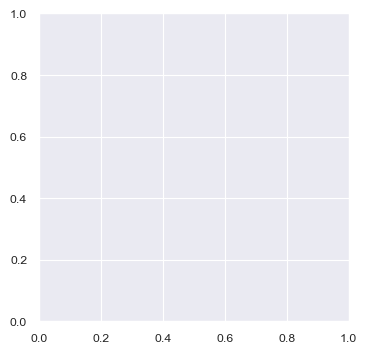

In [66]:

models = ['Reoccurring Bigrams', 'Unique Bigrams', 'Unique Top-1']
labels = models
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_bigrams, 
                         encoding_Glove_nobigrams, 
                         encoding_Glove_unique_top1_bigrams]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), alpha=0.3)

ax1.legend(loc=(0.6, 0.8))
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
if use_real_word_offsets:
    ax1.set_title(dataset+' Audio Encoding (NO offset Anchoring): \n Re-occurring vs unique Bigrams: Residualised GloVe Vectors ')
else:
    ax1.set_title(dataset+' Audio Encoding (OFFSET ANCHORING!): \n Re-occurring vs unique Bigrams: Residualised GloVe Vectors ')

In [29]:
text = " ".join(df["word"].astype(str))

doc = nlp(text)
doc[0].pos_


'PROPN'

In [39]:
matched_PoS = []
token_idx = 0

for word in words_df['word']:
    # get the PoS of the current token
    if token_idx < len(doc):
        matched_PoS.append(doc[token_idx].pos_)
        # advance token_idx until the next word boundary
        token_idx += len(nlp(word))  # number of spaCy tokens in this word
    else:
        # fallback if doc ends unexpectedly
        matched_PoS.append(None)




In [40]:
len(matched_PoS)

5136

In [41]:
matched_PoS[0:10]

['PROPN', 'NUM', 'NOUN', 'ADP', 'DET', 'NOUN', 'ADV', 'PRON', 'DET', 'NOUN']

In [42]:
len(matched_PoS), len(words_df)

(5136, 5136)

### Looking at the unique- Top-1 trials

In [73]:
df = words_df
df['PoS'] = matched_PoS
df['previous PoS'] = df['PoS'].shift(1)
df['previous bigram PoS'] = df['previous PoS'] + '_' + df['PoS']
df['next_word'] = df['word'].shift(-1)
df['previous_word'] = df['word'].shift(1)
df['next bigram']    = df['word'] + '_' + df['next_word']
df['previous bigram']    = df['next bigram'].shift(1)
df.loc[0, 'previous bigram'] = '_Act'
df['indx']      = [x+1 for x in range(len(df))]
df['duration'] = df['offset'] - df['onset']
df['duration previous word'] = df['duration'].shift(1)
df.loc[0, 'duration previous word'] = 0

df_unique_top1   = df.iloc[top_1_and_unique_bigram]
df_not_predicted = df.iloc[not_top_1_indices]
df_unique_top1.head()


,word,onset,offset,PoS,previous PoS,previous bigram PoS,next_word,previous_word,next bigram,previous bigram,indx,duration,duration previous word
5,middle.,5.151,5.391,NOUN,DET,DET_NOUN,So,the,middle._So,the_middle.,6,0.24,0.06
10,where,7.402,7.502,SCONJ,NOUN,NOUN_SCONJ,animals,places,where_animals,places_where,11,0.10,0.27
20,humans,11.002,11.582,NOUN,ADP,ADP_NOUN,for,by,humans_for,by_humans,21,0.58,0.23
33,it,16.442,16.492,PRON,CCONJ,CCONJ_PRON,starts,but,it_starts,but_it,34,0.05,0.27
37,far,17.092,17.232,ADV,ADV,ADV_ADV,from,as,far_from,as_far,38,0.14,0.08


In [74]:
df_not_predicted.head()

,word,onset,offset,PoS,previous PoS,previous bigram PoS,next_word,previous_word,next bigram,previous bigram,indx,duration,duration previous word
0,Act,3.710,3.790,PROPN,None,NaN,"one,",None,"Act_one,",_Act,1,0.08,0.00
1,"one,",3.990,4.190,NUM,PROPN,PROPN_NUM,monkey,Act,"one,_monkey","Act_one,",2,0.20,0.08
2,monkey,4.651,4.931,NOUN,NUM,NUM_NOUN,in,"one,",monkey_in,"one,_monkey",3,0.28,0.20
3,in,4.951,5.011,ADP,NOUN,NOUN_ADP,the,monkey,in_the,monkey_in,4,0.06,0.28
6,So,6.592,6.732,ADV,NOUN,NOUN_ADV,there's,middle.,So_there's,middle._So,7,0.14,0.24


In [44]:
for word, pos in zip(words_df['word'][:20], matched_PoS[:20]):
    print(word, '\t:',pos)

Act 	: PROPN
one, 	: NUM
monkey 	: NOUN
in 	: ADP
the 	: DET
middle. 	: NOUN
So 	: ADV
there's 	: PRON
some 	: DET
places 	: NOUN
where 	: SCONJ
animals 	: NOUN
almost 	: ADV
never 	: ADV
go 	: VERB
places 	: NOUN
that 	: PRON
are 	: AUX
designed 	: VERB
by 	: ADP


In [48]:
pd.set_option('display.max_rows', 10)
display(df_unique_top1)

,word,onset,offset,PoS,previous PoS,previous bigram PoS,next_word,previous_word,next bigram,previous bigram,indx
5,middle.,5.151000,5.391000,NOUN,DET,DET_NOUN,So,the,middle._So,the_middle.,6
10,where,7.402000,7.502000,SCONJ,NOUN,NOUN_SCONJ,animals,places,where_animals,places_where,11
20,humans,11.002000,11.582000,NOUN,ADP,ADP_NOUN,for,by,humans_for,by_humans,21
33,it,16.442000,16.492000,PRON,CCONJ,CCONJ_PRON,starts,but,it_starts,but_it,34
37,far,17.092000,17.232000,ADV,ADV,ADV_ADV,from,as,far_from,as_far,38
...,...,...,...,...,...,...,...,...,...,...,...
5117,human,1792.945428,1793.195428,ADJ,ADV,ADV_ADJ,characteristic,uniquely,human_characteristic,uniquely_human,5118
5122,of,1795.103000,1795.163000,ADP,NOUN,NOUN_ADP,thousands,hundreds,of_thousands,hundreds_of,5123
5124,of,1795.604000,1795.664000,ADP,NOUN,NOUN_ADP,"dollars,",thousands,"of_dollars,",thousands_of,5125
5129,"lives,",1797.345000,1797.765000,NOUN,PRON,PRON_NOUN,to,our,"lives,_to","our_lives,",5130


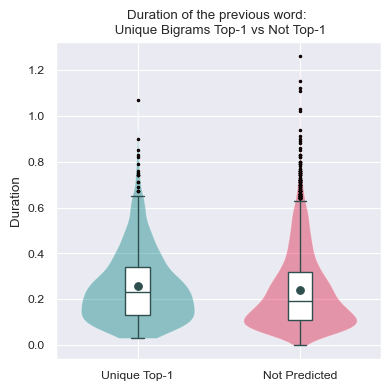

In [80]:
import matplotlib.pyplot as plt
import numpy as np

dur_top1 = df_unique_top1['duration previous word'].values
dur_not_top1 = df_not_predicted['duration previous word'].values

data = [dur_top1, dur_not_top1]
labels = ["Unique Top-1", "Not Predicted"]

fig, ax = plt.subplots(figsize=(4,4))

for i, vals in enumerate(data, start=1):
    # violin
    parts = ax.violinplot(vals, positions=[i], showextrema=False, widths=0.7)
    for pc in parts['bodies']:
        pc.set_facecolor("teal" if i==1 else "crimson")
        pc.set_alpha(0.4)
    
    # boxplot
    box = ax.boxplot(vals, positions=[i], widths=0.15, patch_artist=True,
                     boxprops=dict(facecolor="white", color="darkslategrey"),
                     medianprops=dict(color="darkslategrey"),
                     whiskerprops=dict(color="darkslategrey"),
                     capprops=dict(color="darkslategrey"),
                     flierprops = dict(
                                        marker=".",
                                        markersize=3,
                                        markerfacecolor="red",
                                        linestyle="none"
                    ))
    
    # mean as a dot
    ax.scatter(i, np.mean(vals), color="darkslategrey", zorder=3, s=30)

ax.set_xticks([1,2])
ax.set_xticklabels(labels)
ax.set_ylabel("Duration")
ax.set_title("Duration of the previous word: \n Unique Bigrams Top-1 vs Not Top-1")
plt.tight_layout()
plt.show()

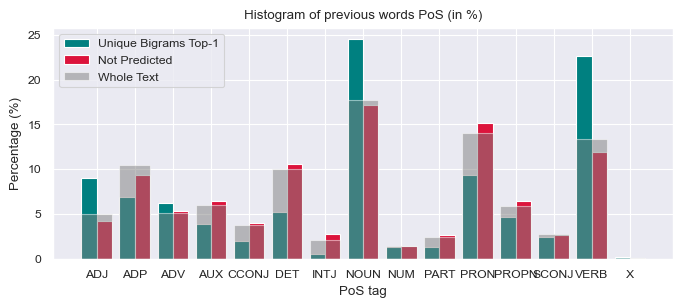

In [90]:

# Count and sort alphabetically, then convert to percentages
counts1 = df_unique_top1['previous PoS'].value_counts(normalize=True).sort_index() * 100
counts2 = df_not_predicted['previous PoS'].value_counts(normalize=True).sort_index() * 100
counts3  = df['previous PoS'].value_counts(normalize=True).sort_index() * 100

# Combine the index to cover all POS tags
all_tags = counts1.index.union(counts2.index).union(counts3.index)

# Reindex to include all tags, filling missing with 0
counts1 = counts1.reindex(all_tags, fill_value=0)
counts2 = counts2.reindex(all_tags, fill_value=0)
counts3 = counts3.reindex(all_tags, fill_value=0)

# Plot
plt.figure(figsize=(8,3))
width = 0.4
x = range(len(all_tags))

plt.bar([i - width/2 for i in x], counts1, width=width, color='teal', label='Unique Bigrams Top-1')
plt.bar([i + width/2 for i in x], counts2, width=width, color='crimson', label='Not Predicted')
plt.bar(x, counts3, width=width*2, color='gray', alpha=0.5, label='Whole Text') 

plt.xticks(x, all_tags)
plt.xlabel('PoS tag')
plt.ylabel('Percentage (%)')
plt.title('Histogram of previous words PoS (in %)')
plt.legend()
plt.show()



/var/folders/0s/rfyt86_x3dd79y121cm9vtrr0000gn/T/ipykernel_98511/3788154544.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_top1['PoS_type']   = df_unique_top1['previous PoS'].apply(map_content)
/var/folders/0s/rfyt86_x3dd79y121cm9vtrr0000gn/T/ipykernel_98511/3788154544.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_not_predicted['PoS_type'] = df_not_predicted['previous PoS'].apply(map_content)


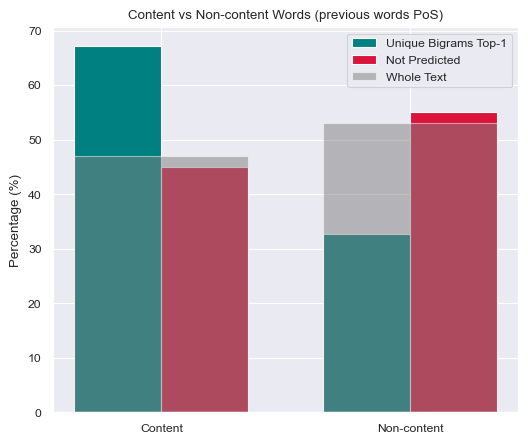

In [91]:
# Define mapping
content_pos = {'NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV'}

def map_content(pos):
    return 'Content' if pos in content_pos else 'Non-content'

# Apply mapping
df_unique_top1['PoS_type']   = df_unique_top1['previous PoS'].apply(map_content)
df_not_predicted['PoS_type'] = df_not_predicted['previous PoS'].apply(map_content)
df['PoS_type']               = df['previous PoS'].apply(map_content)

# Compute percentages
counts1 = df_unique_top1['PoS_type'].value_counts(normalize=True).reindex(['Content','Non-content'], fill_value=0) * 100
counts2 = df_not_predicted['PoS_type'].value_counts(normalize=True).reindex(['Content','Non-content'], fill_value=0) * 100
counts = df['PoS_type'].value_counts(normalize=True).reindex(['Content','Non-content'], fill_value=0) * 100

# Plot side-by-side bars
plt.figure(figsize=(6,5))
width = 0.35
x = [0, 1]

plt.bar([i - width/2 for i in x], counts1, width=width, color='teal', label='Unique Bigrams Top-1')
plt.bar([i + width/2 for i in x], counts2, width=width, color='crimson', label='Not Predicted')
plt.bar(x, counts, width=width*2, color='gray', alpha=0.5, label='Whole Text')

plt.xticks(x, ['Content', 'Non-content'])
plt.ylabel('Percentage (%)')
plt.title('Content vs Non-content Words (previous words PoS)')
plt.legend()
plt.show()


In [93]:
df_unique_top1.head()

,word,onset,offset,PoS,previous PoS,previous bigram PoS,next_word,previous_word,next bigram,previous bigram,indx,duration,duration previous word,PoS_type,word_type,group
5,middle.,5.151,5.391,NOUN,DET,DET_NOUN,So,the,middle._So,the_middle.,6,0.24,0.06,Non-content,Non-content,Unique Top-1
10,where,7.402,7.502,SCONJ,NOUN,NOUN_SCONJ,animals,places,where_animals,places_where,11,0.10,0.27,Content,Non-content,Unique Top-1
20,humans,11.002,11.582,NOUN,ADP,ADP_NOUN,for,by,humans_for,by_humans,21,0.58,0.23,Non-content,Non-content,Unique Top-1
33,it,16.442,16.492,PRON,CCONJ,CCONJ_PRON,starts,but,it_starts,but_it,34,0.05,0.27,Non-content,Non-content,Unique Top-1
37,far,17.092,17.232,ADV,ADV,ADV_ADV,from,as,far_from,as_far,38,0.14,0.08,Content,Non-content,Unique Top-1


/var/folders/0s/rfyt86_x3dd79y121cm9vtrr0000gn/T/ipykernel_98511/3765954455.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PoS_type'] = df['previous PoS'].apply(map_content)
/var/folders/0s/rfyt86_x3dd79y121cm9vtrr0000gn/T/ipykernel_98511/3765954455.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_unique_top1['group'] = 'Unique Top-1'
/var/folders/0s/rfyt86_x3dd79y121cm9vtrr0000gn/T/ipykernel_98511/3765954455.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

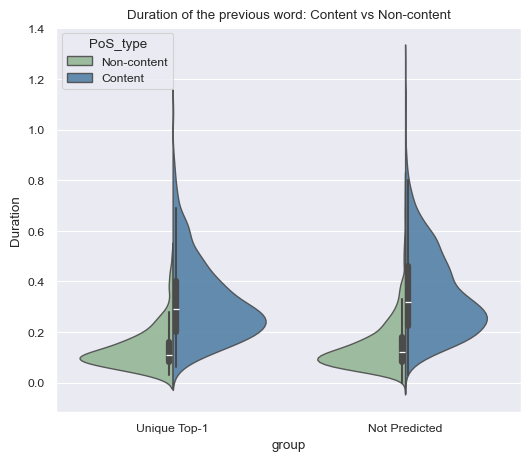

In [99]:


# First, create a new column 'word_type'
content_pos = {'NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV'}

def map_content(pos):
    return 'Content' if pos in content_pos else 'Non-content'

for df in [df_unique_top1, df_not_predicted]:
    df['PoS_type'] = df['previous PoS'].apply(map_content)

# Combine the two dataframes, add a column for group
df_unique_top1['group'] = 'Unique Top-1'
df_not_predicted['group'] = 'Not Predicted'
df_combined = pd.concat([df_unique_top1, df_not_predicted])

plt.figure(figsize=(6,5))
sns.violinplot(
    data=df_combined,
    x='group',
    y='duration previous word',
    hue='PoS_type',
    split=True,
    palette={'Content':'steelblue', 'Non-content':'darkseagreen'},
    inner='box',  # shows boxplot inside violin
    alpha=0.9
)
plt.ylabel("Duration")
plt.title("Duration of the previous word: Content vs Non-content")
plt.show()


In [105]:
words_df['is_top_1'] = is_top_1
words_df['is_top_5'] = is_top_5
#rename indx column to bigram_index
words_df = words_df.rename(columns={'indx': 'bigram_index'})
words_df['word_index'] = range(len(words_df))
words_df.head()


,word,onset,offset,PoS,previous PoS,previous bigram PoS,next_word,previous_word,next bigram,previous bigram,bigram_index,duration,duration previous word,PoS_type,is_top_1,is_top_5,word_index
0,Act,3.710,3.790,PROPN,None,NaN,"one,",None,"Act_one,",_Act,1,0.08,0.00,Non-content,False,False,0
1,"one,",3.990,4.190,NUM,PROPN,PROPN_NUM,monkey,Act,"one,_monkey","Act_one,",2,0.20,0.08,Content,False,False,1
2,monkey,4.651,4.931,NOUN,NUM,NUM_NOUN,in,"one,",monkey_in,"one,_monkey",3,0.28,0.20,Non-content,False,False,2
3,in,4.951,5.011,ADP,NOUN,NOUN_ADP,the,monkey,in_the,monkey_in,4,0.06,0.28,Content,False,False,3
4,the,5.051,5.111,DET,ADP,ADP_DET,middle.,in,the_middle.,in_the,5,0.06,0.06,Non-content,True,True,4


In [107]:

PoS_percentage_whole_text  = words_df['previous PoS'].value_counts(normalize=True).sort_index() * 100
PoS_percentage_whole_text

previous PoS
ADJ       4.926972
ADP      10.477118
ADV       5.141188
AUX       5.998053
CCONJ     3.758520
           ...    
PRON     14.021422
PROPN     5.881207
SCONJ     2.765336
VERB     13.320351
X         0.038948
Name: proportion, Length: 15, dtype: float64

In [117]:
np.unique(is_top_1, return_counts=True)

(array([False,  True]), array([3651, 1485]))

In [128]:
def max_feasible_target_size(df, PoS_percentage_whole_text):
    """
    Compute the maximum possible target size such that sampling
    according to PoS_percentage_whole_text does not require replacement.
    """
    # Count available samples per PoS
    available_counts = df['previous PoS'].value_counts()
    
    # Keep only PoS present in both
    valid_pos = PoS_percentage_whole_text.index.intersection(available_counts.index)
    
    # Convert percentages to probabilities
    probs = PoS_percentage_whole_text.loc[valid_pos] / 100
    
    # Compute max feasible total size for each PoS
    max_per_pos = available_counts.loc[valid_pos] / probs
    
    # The overall limit is the smallest across all PoS
    max_total = int(np.floor(max_per_pos.min()))
    
    return max_total

max_feasible_target_size(df_not_top1, PoS_percentage_whole_text)


2567

In [154]:


def subsample_without_replacement(df, PoS_percentage_whole_text, target_size, random_state=None):
    """
    Subsample df to target_size while keeping PoS distribution as close as possible
    to PoS_percentage_whole_text, without replacement.
    Uses 'previous PoS' column.
    """
    np.random.seed(random_state)
    
    # Keep only PoS present in this subset
    subset_pos = df['previous PoS'].unique()
    probs = PoS_percentage_whole_text[PoS_percentage_whole_text.index.isin(subset_pos)]
    probs = probs / probs.sum()  # normalize
    
    # Compute raw number of samples per PoS
    n_samples_raw = (probs * target_size).astype(int)
    
    # Clip to available rows (no replacement)
    n_samples = {pos: min(n_samples_raw[pos], len(df[df['previous PoS'] == pos])) for pos in n_samples_raw.index}
    
    sampled_dfs = []
    for pos, n in n_samples.items():
        if n > 0:
            df_pos = df[df['previous PoS'] == pos]
            sampled_dfs.append(df_pos.sample(n=n, replace=False, random_state=random_state))
    
    return pd.concat(sampled_dfs).sample(frac=1, random_state=random_state)  # shuffle

# Split the dataframe
df_top1 = words_df[words_df['is_top_1']].copy()
df_not_top1 = words_df[~words_df['is_top_1']].copy()

# Set target sizes
target_size_top1 = 1000
target_size_not_top1 = target_size_top1 # this would be the maximum that preserves the PoS distribution

# Subsample without replacement
sub_top1 = subsample_without_replacement(df_top1, PoS_percentage_whole_text, target_size_top1, random_state=42)
sub_not_top1 = subsample_without_replacement(df_not_top1, PoS_percentage_whole_text, target_size_not_top1, random_state=42)

# Check resulting distributions
print('All \t Top-1 \t Not Top-1 \n', '-'*24)
for all, top1, not_top1 in zip(words_df['previous PoS'].value_counts(normalize=True) * 100, 
                             sub_top1['previous PoS'].value_counts(normalize=True) * 100, 
                             sub_not_top1['previous PoS'].value_counts(normalize=True) * 100):
    print('{:.2f} \t {:.2f} \t {:.2f}'.format(all, top1, not_top1))




All 	 Top-1 	 Not Top-1 
 ------------------------
17.76 	 18.08 	 17.84
14.02 	 14.30 	 14.11
13.32 	 13.59 	 13.41
10.48 	 10.62 	 10.48
9.99 	 10.11 	 9.98
6.00 	 6.03 	 5.95
5.88 	 5.92 	 5.85
5.14 	 5.21 	 5.14
4.93 	 5.01 	 4.94
3.76 	 3.78 	 3.73
2.77 	 2.76 	 2.72
2.45 	 2.45 	 2.42
2.10 	 1.33 	 2.12
1.36 	 0.82 	 1.31


In [155]:
len(sub_top1), len(sub_not_top1)

(979, 992)

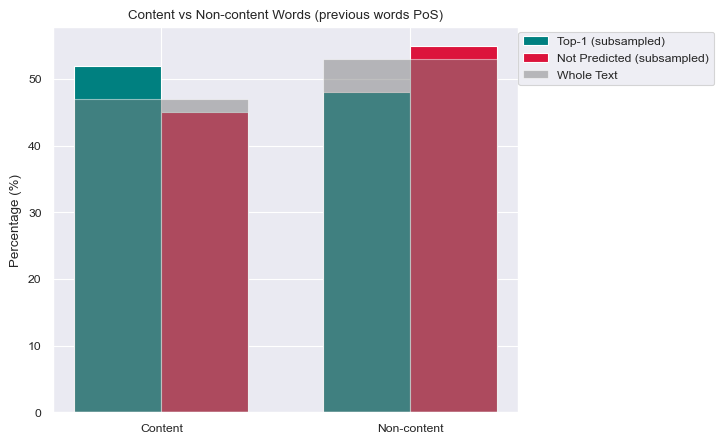

In [156]:
# Define mapping
content_pos = {'NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV'}

def map_content(pos):
    return 'Content' if pos in content_pos else 'Non-content'

# Apply mapping
df_top1['PoS_type']   = df_top1['previous PoS'].apply(map_content)
df_not_top1['PoS_type'] = df_not_top1['previous PoS'].apply(map_content)
df_not_top1['previous PoS'].apply(map_content)
df['PoS_type']               = df['previous PoS'].apply(map_content)

# Compute percentages
counts1 = df_top1['PoS_type'].value_counts(normalize=True).reindex(['Content','Non-content'], fill_value=0) * 100
counts2 = df_not_top1['PoS_type'].value_counts(normalize=True).reindex(['Content','Non-content'], fill_value=0) * 100
counts  = words_df['PoS_type'].value_counts(normalize=True).reindex(['Content','Non-content'], fill_value=0) * 100

# Plot side-by-side bars
plt.figure(figsize=(6,5))
width = 0.35
x = [0, 1]

plt.bar([i - width/2 for i in x], counts1, width=width, color='teal', label='Top-1 (subsampled)')
plt.bar([i + width/2 for i in x], counts2, width=width, color='crimson', label='Not Predicted (subsampled)')
plt.bar(x, counts, width=width*2, color='gray', alpha=0.5, label='Whole Text')

plt.xticks(x, ['Content', 'Non-content'])
plt.ylabel('Percentage (%)')
plt.title('Content vs Non-content Words (previous words PoS)')
plt.legend(loc=(1, 0.85))
plt.show()


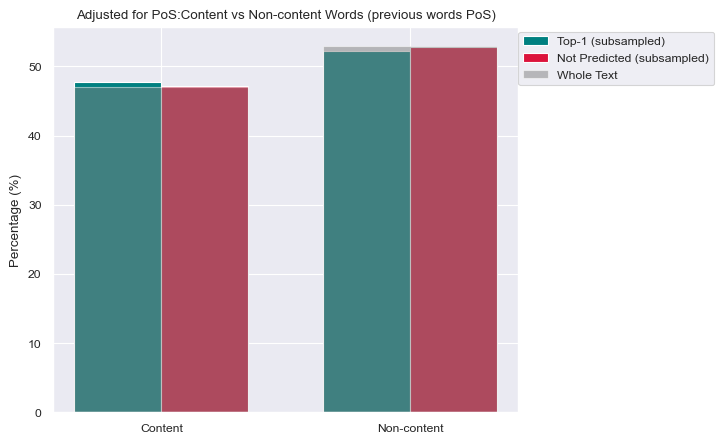

In [161]:
# Define mapping
content_pos = {'NOUN', 'PROPN', 'VERB', 'ADJ', 'ADV'}

def map_content(pos):
    return 'Content' if pos in content_pos else 'Non-content'

# Apply mapping
sub_top1['PoS_type']     = sub_top1['previous PoS'].apply(map_content)
sub_not_top1['PoS_type'] = sub_not_top1['previous PoS'].apply(map_content)
words_df['PoS_type']     = words_df['previous PoS'].apply(map_content)

# Compute percentages
counts1 = sub_top1['PoS_type'].value_counts(normalize=True).reindex(['Content','Non-content'], fill_value=0) * 100
counts2 = sub_not_top1['PoS_type'].value_counts(normalize=True).reindex(['Content','Non-content'], fill_value=0) * 100
counts  = words_df['PoS_type'].value_counts(normalize=True).reindex(['Content','Non-content'], fill_value=0) * 100

# Plot side-by-side bars
plt.figure(figsize=(6,5))
width = 0.35
x = [0, 1]

plt.bar([i - width/2 for i in x], counts1, width=width, color='teal', label='Top-1 (subsampled)')
plt.bar([i + width/2 for i in x], counts2, width=width, color='crimson', label='Not Predicted (subsampled)')
plt.bar(x, counts, width=width*2, color='gray', alpha=0.5, label='Whole Text')

plt.xticks(x, ['Content', 'Non-content'])
plt.ylabel('Percentage (%)')
plt.title('Adjusted for PoS:Content vs Non-content Words (previous words PoS)')
plt.legend(loc=(1, 0.85))
plt.show()


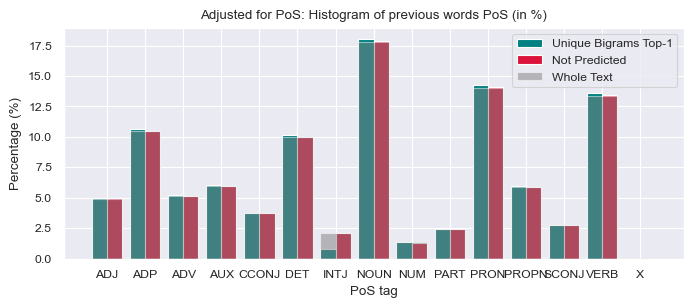

In [162]:

# Count and sort alphabetically, then convert to percentages
counts1 = sub_top1['previous PoS'].value_counts(normalize=True).sort_index() * 100
counts2 = sub_not_top1['previous PoS'].value_counts(normalize=True).sort_index() * 100
counts3  = words_df['previous PoS'].value_counts(normalize=True).sort_index() * 100

# Combine the index to cover all POS tags
all_tags = counts1.index.union(counts2.index).union(counts3.index)

# Reindex to include all tags, filling missing with 0
counts1 = counts1.reindex(all_tags, fill_value=0)
counts2 = counts2.reindex(all_tags, fill_value=0)
counts3 = counts3.reindex(all_tags, fill_value=0)

# Plot
plt.figure(figsize=(8,3))
width = 0.4
x = range(len(all_tags))

plt.bar([i - width/2 for i in x], counts1, width=width, color='teal', label='Unique Bigrams Top-1')
plt.bar([i + width/2 for i in x], counts2, width=width, color='crimson', label='Not Predicted')
plt.bar(x, counts3, width=width*2, color='gray', alpha=0.5, label='Whole Text') 

plt.xticks(x, all_tags)
plt.xlabel('PoS tag')
plt.ylabel('Percentage (%)')
plt.title('Adjusted for PoS: Histogram of previous words PoS (in %)')
plt.legend()
plt.show()


In [157]:
indx_top_1     = sub_top1.word_index
indx_not_top_1 = sub_not_top1.word_index

In [158]:
y = y_acoustics

X_Glove_top_1     = X_Glove[indx_top_1]
X_Glove_not_top_1 = X_Glove[indx_not_top_1]

y_top_1     = y[indx_top_1]
y_not_top_1 = y[indx_not_top_1]

y_top_1 = np.swapaxes(np.swapaxes(y_top_1, 1, 2), 0, 1)
y_not_top_1 = np.swapaxes(np.swapaxes(y_not_top_1, 1, 2), 0, 1)

# compute the encoding of the acoustics for each split
encoding_Glove_top_1     = brainscore_no_coef(X_Glove_top_1, y_top_1)
encoding_Glove_not_top_1 = brainscore_no_coef(X_Glove_not_top_1, y_not_top_1)

We are now in the brainscore_no_coef method, and y has shape:
(9, 979, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 992, 157)


Text(0.5, 1.0, 'Goldstein Audio Encoding: PoS adjusted: Original Vectors Top 1')

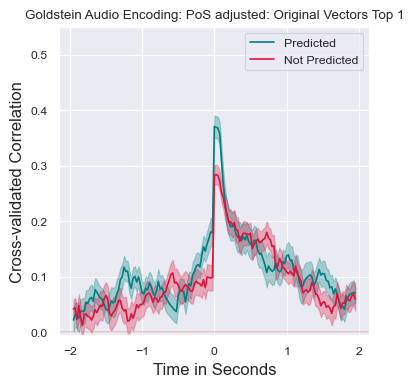

In [159]:
# get model names
from lingpred_new.plotting import times_100, lowerCI, upperCI, reshape

models = ['Top 1', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_top_1, encoding_Glove_not_top_1]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: PoS adjusted: Original Vectors ' + models[0])

## Let's look at what happens when we remove re-occorring bigrams and do the split then:

In [27]:
from lingpred_new.utils import get_bigram_mask

bigram_mask = np.array(get_bigram_mask(words_df))

# apply the mask to all our X, y matrices and other masks
y        = y_acoustics[bigram_mask]
X_Glove_nb  = X_Glove[bigram_mask]
is_top_5_nb = np.array(is_top_5)[bigram_mask]
is_top_1_nb = np.array(is_top_1)[bigram_mask]
is_not_top_5_nb = np.array(is_not_top_5)[bigram_mask]
is_not_top_1_nb = np.array(is_not_top_1)[bigram_mask]


X_Glove_top_1     = X_Glove_nb[is_top_1_nb]
X_Glove_top_5     = X_Glove_nb[is_top_5_nb]
X_Glove_not_top_1 = X_Glove_nb[is_not_top_1_nb]
X_Glove_not_top_5 = X_Glove_nb[is_not_top_5_nb]

y_top_1     = y[is_top_1_nb]
y_top_5     = y[is_top_5_nb]
y_not_top_1 = y[is_not_top_1_nb]
y_not_top_5 = y[is_not_top_5_nb]

y_top_1 = np.swapaxes(np.swapaxes(y_top_1, 1, 2), 0, 1)
y_top_5 = np.swapaxes(np.swapaxes(y_top_5, 1, 2), 0, 1)
y_not_top_1 = np.swapaxes(np.swapaxes(y_not_top_1, 1, 2), 0, 1)
y_not_top_5 = np.swapaxes(np.swapaxes(y_not_top_5, 1, 2), 0, 1)

       onset  duration        sample           type        word    offset  \
3   1.089189  0.129705  46637.372038  word_onset_01         THE  1.218895   
6   1.218895  0.678458  46793.018296  word_onset_01  ADVENTURES  1.897353   
15  1.897353  0.089796  47607.167956  word_onset_01          OF  1.987149   
18  1.987149  0.488889  47714.923058  word_onset_01    SHERLOCK  2.476037   
24  2.476037  0.698413  48301.589725  word_onset_01      HOLMES  3.174450   

     next_word           bigram  
3   ADVENTURES   THE_ADVENTURES  
6           OF    ADVENTURES_OF  
15    SHERLOCK      OF_SHERLOCK  
18      HOLMES  SHERLOCK_HOLMES  
24           A         HOLMES_A  


In [29]:
len(is_top_1_nb), len(is_top_1)

(6366, 8622)

In [44]:
# print the unique count for each list 
np.unique(is_top_1, return_counts=True), np.unique(is_top_1_nb, return_counts=True)

((array([False,  True]), array([5547, 3074])),
 (array([False,  True]), array([4258, 2107])))

In [28]:
# compute the encoding of the acoustics for each split
encoding_Glove_top_1     = brainscore_no_coef(X_Glove_top_1, y_top_1)
encoding_Glove_top_5     = brainscore_no_coef(X_Glove_top_5, y_top_5)
encoding_Glove_not_top_1 = brainscore_no_coef(X_Glove_not_top_1, y_not_top_1)
encoding_Glove_not_top_5 = brainscore_no_coef(X_Glove_not_top_5, y_not_top_5)

We are now in the brainscore_no_coef method, and y has shape:
(9, 2108, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 3542, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 4258, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 2824, 157)


## ... and now for the residualised vectors without bigrams 

In [35]:
# Since we are working with residualised vectors, which is not defined for the first word, we need to drop that for our is_top_ masks
y = y_acoustics[1:]

is_top_1     = is_top_1[1:]
is_top_5     = is_top_5[1:]
is_not_top_1 = is_not_top_1[1:]
is_not_top_5 = is_not_top_5[1:]

len(is_top_1), len(is_top_5), len(is_not_top_1), len(is_not_top_5), y.shape

(8621, 8621, 8621, 8621, (8621, 157, 9))

In [40]:
bigram_mask = get_bigram_mask(words_df)
bigram_mask_residualised = [x-1 for x in bigram_mask if x>0]
bigram_mask_residualised[:10], len(bigram_mask_residualised)

       onset  duration        sample           type        word    offset  \
3   1.089189  0.129705  46637.372038  word_onset_01         THE  1.218895   
6   1.218895  0.678458  46793.018296  word_onset_01  ADVENTURES  1.897353   
15  1.897353  0.089796  47607.167956  word_onset_01          OF  1.987149   
18  1.987149  0.488889  47714.923058  word_onset_01    SHERLOCK  2.476037   
24  2.476037  0.698413  48301.589725  word_onset_01      HOLMES  3.174450   

     next_word           bigram  
3   ADVENTURES   THE_ADVENTURES  
6           OF    ADVENTURES_OF  
15    SHERLOCK      OF_SHERLOCK  
18      HOLMES  SHERLOCK_HOLMES  
24           A         HOLMES_A  


([np.int64(0),
  np.int64(1),
  np.int64(2),
  np.int64(3),
  np.int64(4),
  np.int64(5),
  np.int64(6),
  np.int64(7),
  np.int64(8),
  np.int64(10)],
 6365)

In [41]:

# apply the mask to all our X, y matrices and other masks
y                         = y[bigram_mask_residualised]
X_Glove_residualised_nb   = X_Glove_residualised[bigram_mask_residualised]
is_top_5_nb               = np.array(is_top_5)[bigram_mask_residualised]
is_top_1_nb               = np.array(is_top_1)[bigram_mask_residualised]
is_not_top_5_nb           = np.array(is_not_top_5)[bigram_mask_residualised]
is_not_top_1_nb           = np.array(is_not_top_1)[bigram_mask_residualised]


# split into Top-1, Top-5 and not-Top
X_Glove_residualised_top_1     = X_Glove_residualised_nb[is_top_1_nb]
X_Glove_residualised_top_5     = X_Glove_residualised_nb[is_top_5_nb]
X_Glove_residualised_not_top_1 = X_Glove_residualised_nb[is_not_top_1_nb]
X_Glove_residualised_not_top_5 = X_Glove_residualised_nb[is_not_top_5_nb]

y_top_1     = y[is_top_1_nb]
y_top_5     = y[is_top_5_nb]
y_not_top_1 = y[is_not_top_1_nb]
y_not_top_5 = y[is_not_top_5_nb]

# swapping y matrices to the right shape
y_top_1 = np.swapaxes(np.swapaxes(y_top_1, 1, 2), 0, 1)
y_top_5 = np.swapaxes(np.swapaxes(y_top_5, 1, 2), 0, 1)
y_not_top_1 = np.swapaxes(np.swapaxes(y_not_top_1, 1, 2), 0, 1)
y_not_top_5 = np.swapaxes(np.swapaxes(y_not_top_5, 1, 2), 0, 1)

# compute the encoding of the acoustics for each split
encoding_Glove_residualised_top_1     = brainscore_no_coef(X_Glove_residualised_top_1, y_top_1)
encoding_Glove_residualised_top_5     = brainscore_no_coef(X_Glove_residualised_top_5, y_top_5)
encoding_Glove_residualised_not_top_1 = brainscore_no_coef(X_Glove_residualised_not_top_1, y_not_top_1)
encoding_Glove_residualised_not_top_5 = brainscore_no_coef(X_Glove_residualised_not_top_5, y_not_top_5)

We are now in the brainscore_no_coef method, and y has shape:
(9, 2107, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 3541, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 4258, 157)
We are now in the brainscore_no_coef method, and y has shape:
(9, 2824, 157)


## Plotting

Text(0.5, 1.0, 'Armeni Audio Encoding: No Bigrams: Original Vectors Top 1')

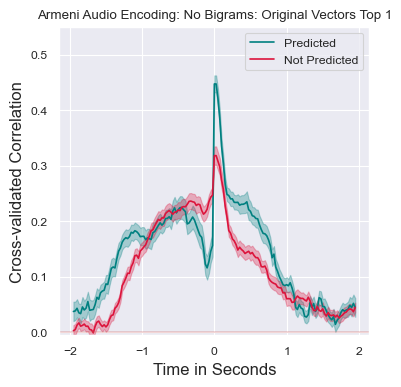

In [33]:
# get model names
from lingpred_new.plotting import times_100, lowerCI, upperCI, reshape

models = ['Top 1', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_top_1, encoding_Glove_not_top_1]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: No Bigrams: Original Vectors ' + models[0])

Text(0.5, 1.0, 'Armeni Audio Encoding: No Bigrams: Original Vectors Top 5')

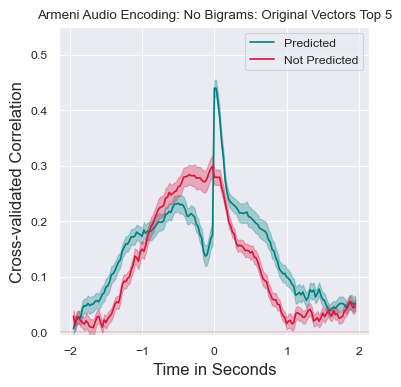

In [34]:
models = ['Top 5', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_top_5, encoding_Glove_not_top_5]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: No Bigrams: Original Vectors ' + models[0])

Text(0.5, 1.0, 'Armeni Audio Encoding: No Bigrams: Residual Vectors Top 1')

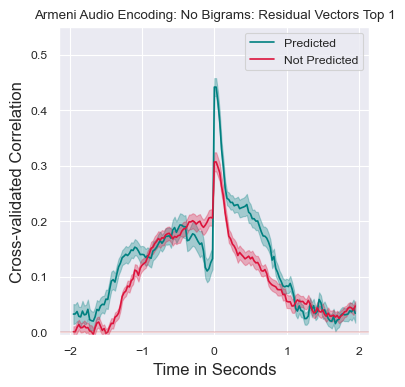

In [42]:

models = ['Top 1', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_residualised_top_1, encoding_Glove_residualised_not_top_1]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: No Bigrams: Residual Vectors ' + models[0])

Text(0.5, 1.0, 'Armeni Audio Encoding: No Bigrams: Residual Vectors Top 5')

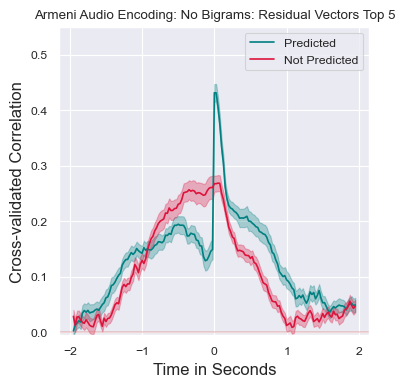

In [43]:

models = ['Top 5', 'Not Predicted']
labels = ['Predicted', 'Not Predicted']
    
    
fig, (ax1) = plt.subplots(1, 1, figsize=(4, 4))

for i, key in enumerate([encoding_Glove_residualised_top_5, encoding_Glove_residualised_not_top_5]):
    ax1.plot(times_100, key.mean(axis=0).mean(axis=0), c=colours[models[i]], label=labels[i])   
    ax1.fill_between(times_100, lowerCI(reshape(key)), 
                                upperCI(reshape(key)), color=colours[models[i]], alpha=0.3)

ax1.legend()
ax1.set_ylim([-0.005, 0.55])
ax1.set_xlabel('Time in Seconds', fontsize=12)
ax1.set_ylabel('Cross-validated Correlation', fontsize=12)
ax1.axhline(c='indianred',  alpha=0.3)
ax1.set_title(dataset+' Audio Encoding: No Bigrams: Residual Vectors ' + models[0])